In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Input, Conv2D, Activation, Multiply, Reshape, MaxPooling2D


2024-05-11 16:20:37.805287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 16:20:37.805415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 16:20:37.935596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout,Flatten,MaxPooling2D,Conv2D,Activation
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
import os
import glob

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [4]:
encoder=OneHotEncoder()
encoder.fit([[0],[1],[2],[3],[4],[5]])

OneHotEncoder()

# Load the dataset

In [5]:
image_data='/kaggle/input/emotion-recognition-dataset/dataset'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,Surprise
1,Angry
2,Neutral
3,Sad
4,Happy
5,Ahegao


In [6]:
files_l = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files_l)
labels_l = [os.path.dirname(i).split("/")[-1] for i in files_l]
data_l = zip(files_l, labels_l)

In [7]:
dataframe_l = pd.DataFrame(data_l, columns = ["Image", "Label"])

In [8]:
print(dataframe_l )

                                                   Image    Label
0      /kaggle/input/emotion-recognition-dataset/data...  Neutral
1      /kaggle/input/emotion-recognition-dataset/data...  Neutral
2      /kaggle/input/emotion-recognition-dataset/data...  Neutral
3      /kaggle/input/emotion-recognition-dataset/data...    Happy
4      /kaggle/input/emotion-recognition-dataset/data...      Sad
...                                                  ...      ...
15448  /kaggle/input/emotion-recognition-dataset/data...   Ahegao
15449  /kaggle/input/emotion-recognition-dataset/data...    Happy
15450  /kaggle/input/emotion-recognition-dataset/data...      Sad
15451  /kaggle/input/emotion-recognition-dataset/data...    Happy
15452  /kaggle/input/emotion-recognition-dataset/data...      Sad

[15453 rows x 2 columns]


### To know the shape of the image

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
# Load the image
image_path = "/kaggle/input/emotion-recognition-dataset/dataset/Ahegao/cropped_emotions.16023~ahegao.png"

image = Image.open(image_path)

# Print the size of the image
print("Image size:", image.size)

Image size: (264, 382)


## Count the no.of images in each cateogary

In [10]:
# Define the directory containing the dataset
dataset_dir = '/kaggle/input/emotion-recognition-dataset/dataset'
# List all directories (which represent classes)
class_directories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
# Define an empty dictionary to store the counts of images for each class
class_counts = {}
# Iterate through each class directory and count the number of files
total_images = 0
for class_dir in class_directories:
    class_path = os.path.join(dataset_dir, class_dir)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = file_count
    total_images += file_count

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Print the total number of images
print(f"Total images: {total_images}")

Surprise: 1234 images
Angry: 1313 images
Neutral: 4027 images
Sad: 3934 images
Happy: 3740 images
Ahegao: 1205 images
Total images: 15453


# Data Visualisation

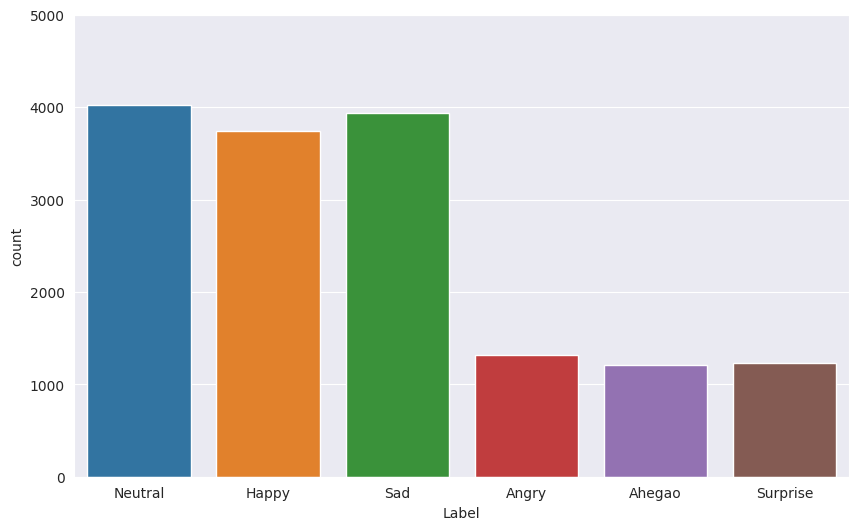

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x=dataframe_l ["Label"])

# Get the counts for each class
class_counts = dataframe_l ["Label"].value_counts()
# Rotate x-axis labels if needed
plt.xticks(rotation=0)

# Limit y-axis range up to 6000
plt.ylim(0, 5000)

# Show plot
plt.show()

# Data Preprocessing

## Defining image paramater

In [12]:
image_data = '/kaggle/input/emotion-recognition-dataset/dataset'
train_data_dir = image_data
train_data_dir = image_data
batch_size = 64
target_size = (224, 224)
validation_split= 0.2

## Defining augmentation parameters

In [13]:
augmentation_params = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


### Count images in each class

In [14]:
def count_images(class_name):
    class_path = os.path.join(train_data_dir, class_name)
    return len(os.listdir(class_path))

### Determining the classes to augment


In [15]:
classes_to_augment = ['Neutral','Sad','Happy','Ahegao', 'Angry', 'Surprise']
target_count = 4500

### Created an output directory


In [16]:
output_dir = '/kaggle/working/augmented_images'

## Performing data augmentation

In [17]:
for class_name in classes_to_augment:
    current_count = count_images(class_name)
    if current_count < target_count:
        augment_count = target_count - current_count
        augment_dir = os.path.join(output_dir, class_name)  # Save augmented images to a new directory
        os.makedirs(augment_dir, exist_ok=True)  # Create the directory if it doesn't exist
        augment_datagen = ImageDataGenerator(**augmentation_params)
        augment_generator = augment_datagen.flow_from_directory(
            train_data_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            classes=[class_name],
            save_to_dir=augment_dir,
            save_prefix='augmented',
            save_format='png'
        )
        # Generate augmented images until the target count is reached
        i = 0
        for batch in augment_generator:
            i += 1
            if i >= augment_count / batch_size:
                break

Found 4027 images belonging to 1 classes.
Found 3934 images belonging to 1 classes.
Found 3740 images belonging to 1 classes.
Found 1205 images belonging to 1 classes.
Found 1313 images belonging to 1 classes.
Found 1234 images belonging to 1 classes.


## Count of augmented images

In [18]:
# Define the directory containing the dataset
dataset_dir = '/kaggle/working/augmented_images'
# List all directories (which represent classes)
class_directories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
# Iterate through each class directory and count the number of files
total_images = 0
for class_dir in class_directories:
    class_path = os.path.join(dataset_dir, class_dir)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = file_count
    total_images += file_count

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Print the total number of images
print(f"Total images: {total_images}")


Neutral: 512 images
Sad: 576 images
Happy: 768 images
Angry: 3138 images
Surprise: 3236 images
Ahegao: 3306 images
Total images: 11536


## Combining original images and augmented images

In [19]:
import os
import shutil

# Define paths
original_data_path ='/kaggle/input/emotion-recognition-dataset/dataset'
augmented_data_path = '/kaggle/working/augmented_images'
new_data_path = '/kaggle/working/merged_dataset'

# Get the list of classes
classes = os.listdir(original_data_path)
classes

['Surprise', 'Angry', 'Neutral', 'Sad', 'Happy', 'Ahegao']

In [20]:
# Create directories for each class in the new data path
for class_name in classes:
    os.makedirs(os.path.join(new_data_path, class_name), exist_ok=True)

# Copy images from the original data path to the new data path
for class_name in classes:
    original_class_path = os.path.join(original_data_path, class_name)
    new_class_path = os.path.join(new_data_path, class_name)
    for filename in os.listdir(original_class_path):
        shutil.copy(os.path.join(original_class_path, filename), os.path.join(new_class_path, filename))

# Copy images from the augmented data path to the new data path
for class_name in classes:
    augmented_class_path = os.path.join(augmented_data_path, class_name)
    new_class_path = os.path.join(new_data_path, class_name)
    for filename in os.listdir(augmented_class_path):
        shutil.copy(os.path.join(augmented_class_path, filename), os.path.join(new_class_path, filename))

print("Data merge complete.")


Data merge complete.


## Count of combined images

In [21]:
# Define the directory containing the dataset
merged_dataset = '/kaggle/working/merged_dataset'
# List all directories (which represent classes)
class_directories = [d for d in os.listdir(merged_dataset) if os.path.isdir(os.path.join(merged_dataset, d))]

# Iterate through each class directory and count the number of files
total_images = 0
for class_dir in class_directories:
    class_path = os.path.join(merged_dataset, class_dir)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = file_count
    total_images += file_count

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Print the total number of images
print(f"Total images: {total_images}")

Neutral: 4539 images
Sad: 4510 images
Happy: 4508 images
Angry: 4451 images
Surprise: 4470 images
Ahegao: 4511 images
Total images: 26989


In [22]:
image_path2 = "/kaggle/working/merged_dataset/Ahegao/cropped_emotions.16023~ahegao.png"
image2 = Image.open(image_path2)
# Print the size of the image
print("Image size:", image2.size)

Image size: (264, 382)


In [23]:
merged_dataset = '/kaggle/working/merged_dataset'

In [ ]:
import os
os.listdir('/kaggle/working')


## Organising the data into separate paths for each cateogary

In [24]:
data=[]
result=[]

In [25]:
paths=[]
# Process images in 'Ahegao' folder
for r, d, f in os.walk('/kaggle/working/merged_dataset/Ahegao'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))

for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [26]:
paths=[]
# Process images in 'Angry' folder
for r, d, f in os.walk('/kaggle/working/merged_dataset/Angry'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [27]:
paths=[]
# Process images in 'Happy' folder           
for r,d,f in os.walk('/kaggle/working/merged_dataset/Happy'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray())            

In [28]:
paths=[]
# Process images in 'Neutral' folder            
for r,d,f in os.walk('/kaggle/working/merged_dataset/Neutral'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())            

In [29]:
paths=[]
# Process images in 'Sad' folder
for r,d,f in os.walk('/kaggle/working/merged_dataset/Sad'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[4]]).toarray())            

In [30]:
paths=[]
# Process images in 'Surprise' folder         
for r,d,f in os.walk('/kaggle/working/merged_dataset/Surprise'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[5]]).toarray())            

In [31]:
data=np.array(data)
data.shape

(26984, 128, 128, 3)

In [32]:
result=np.array(result)

In [33]:
len(result)

26984

In [34]:
result=result.reshape(26984,6)

# Train-test split

In [35]:
x_train,x_test,y_train,y_test=train_test_split(data,result,test_size=0.2,shuffle=True,random_state=0)

In [36]:
print(len(x_train))
print(len(x_test))

21587
5397


In [37]:
print(len(y_train))
print(len(y_test))

21587
5397


## Adding few more required libraries

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Input, Conv2D, Activation, Multiply, Reshape, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention

## Defining spatial attention mechanism function

In [39]:
def spatial_attention(input_feature):
    kernel_size = 7  # You can adjust this parameter
    attention_feature = Conv2D(1, (kernel_size, kernel_size), padding='same', activation='sigmoid', kernel_initializer='he_normal')(input_feature)
    return Multiply()([input_feature, attention_feature])


## Loading the base model of Xception

In [40]:
base_model_Xception = Xception(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Creating self attention layers

In [41]:
num_attention_heads = 8
key_dim = 64
self_attention = MultiHeadAttention(num_heads=num_attention_heads, key_dim=key_dim)
global_pooling = GlobalAveragePooling2D()
reshape_for_attention = Reshape((1, -1))
self_attention_output = self_attention(reshape_for_attention(global_pooling(base_model_Xception.output)),
                                       reshape_for_attention(global_pooling(base_model_Xception.output)))
# Reshaping self-attention output to match base model output shape
reshape_self_attention_output = Reshape((1, 1, base_model_Xception.output_shape[-1]))(self_attention_output)

## Applying Spatial Attention before final classification layer

In [42]:
attended_output = spatial_attention(base_model_Xception.output)
combined_output = Multiply()([attended_output, reshape_self_attention_output]) # combining self attention & spatial output

# Build the model
Xception_model = Model(inputs=base_model_Xception.input, outputs=combined_output)

## Defining remaining layers for Xception Net

In [45]:
classification_layers = [
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(6, activation='softmax')
]

# Build the model
Xception_output = combined_output
for layer in classification_layers:
    Xception_output = layer(Xception_output)

In [46]:
# Construct the final model
Xception_model = Model(inputs=base_model_Xception.input, outputs=Xception_output)

In [47]:
Xception_model.build((None, 128,128,3))
Xception_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 31,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add[0][0]       

 Total params: 27,918,639 (106.50 MB)

 Trainable params: 27,862,575 (106.29 MB)

 Non-trainable params: 56,064 (219.00 KB)

## Compiling the model

In [48]:
Xception_model.compile(optimizer='Adam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])


## Training model with 25 epoch

In [49]:
Xception_history = Xception_model.fit(x_train,
                    y_train, 
                    epochs=25, 
                    batch_size=64, 
                    verbose=1, 
                    validation_data=(x_test, y_test))

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
I0000 00:00:1715445801.423602     161 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715445801.492553     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


338/338 ━━━━━━━━━━━━━━━━━━━━ 153s 281ms/step - accuracy: 0.6065 - loss: 1.0344 - val_accuracy: 0.6904 - val_loss: 1.0927
Epoch 2/25


W0000 00:00:1715445896.316238     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


338/338 ━━━━━━━━━━━━━━━━━━━━ 63s 186ms/step - accuracy: 0.8611 - loss: 0.3900 - val_accuracy: 0.7413 - val_loss: 0.7507
Epoch 3/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 63s 186ms/step - accuracy: 0.8948 - loss: 0.2908 - val_accuracy: 0.7812 - val_loss: 0.6031
Epoch 4/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 63s 185ms/step - accuracy: 0.9271 - loss: 0.2061 - val_accuracy: 0.8286 - val_loss: 0.5232
Epoch 5/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 63s 185ms/step - accuracy: 0.9402 - loss: 0.1765 - val_accuracy: 0.8045 - val_loss: 0.6433
Epoch 6/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 63s 185ms/step - accuracy: 0.9578 - loss: 0.1265 - val_accuracy: 0.8338 - val_loss: 0.5327
Epoch 7/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 63s 185ms/step - accuracy: 0.9643 - loss: 0.1058 - val_accuracy: 0.8299 - val_loss: 0.6444
Epoch 8/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 63s 185ms/step - accuracy: 0.9679 - loss: 0.0933 - val_accuracy: 0.8533 - val_loss: 0.5807
Epoch 9/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 63s 185ms/step - accuracy: 0.9730 - loss: 0.0873 - val

## Evaluation Metrics

In [50]:
print("Training Accuracy:", Xception_history.history['accuracy'][-1])
print("Validation Accuracy:", Xception_history.history['val_accuracy'][-1])

Training Accuracy: 0.9887895584106445
Validation Accuracy: 0.8619603514671326


In [51]:
print("Training Loss:",Xception_history.history['loss'][-1])
print("Test Loss:",Xception_history.history['val_loss'][-1])

Training Loss: 0.03511339798569679
Test Loss: 0.5416402816772461


In [52]:
final_epoch_predictions_Xception = Xception_model.predict(x_test)
final_epoch_predicted_labels_Xception = np.argmax(final_epoch_predictions_Xception, axis=1)
true_labels_Xception = np.argmax(y_test, axis=1)

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step


W0000 00:00:1715447643.629106     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [53]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report,f1_score
from tensorflow.keras.models import clone_model

In [54]:
precision_Xception = precision_score(true_labels_Xception, final_epoch_predicted_labels_Xception, average='weighted')
recall_Xception= recall_score(true_labels_Xception, final_epoch_predicted_labels_Xception, average='weighted')
f1_Xception = f1_score(true_labels_Xception, final_epoch_predicted_labels_Xception, average='weighted')

print("Precision:", precision_Xception)
print("Recall:", recall_Xception)
print("F1-score:", f1_Xception)


Precision: 0.8647098609963357
Recall: 0.8619603483416713
F1-score: 0.8624425740111836


In [55]:
conf_matrix_Xception= confusion_matrix(true_labels_Xception, final_epoch_predicted_labels_Xception)
print("Confusion Matrix:\n", conf_matrix_Xception)

Confusion Matrix:
 [[860   0   0   0   3   2]
 [  5 796   4  36  28  22]
 [  3  15 775  62  16  20]
 [ 10  21   5 747 139  20]
 [  8  46   9 162 634  14]
 [ 26  15  14  32   8 840]]


## Classification Report

In [56]:
class_report_Xception = classification_report(true_labels_Xception, final_epoch_predicted_labels_Xception)
print("Classification Report:\n", class_report_Xception)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       865
           1       0.89      0.89      0.89       891
           2       0.96      0.87      0.91       891
           3       0.72      0.79      0.75       942
           4       0.77      0.73      0.75       873
           5       0.92      0.90      0.91       935

    accuracy                           0.86      5397
   macro avg       0.87      0.86      0.86      5397
weighted avg       0.86      0.86      0.86      5397



## Plot graphs

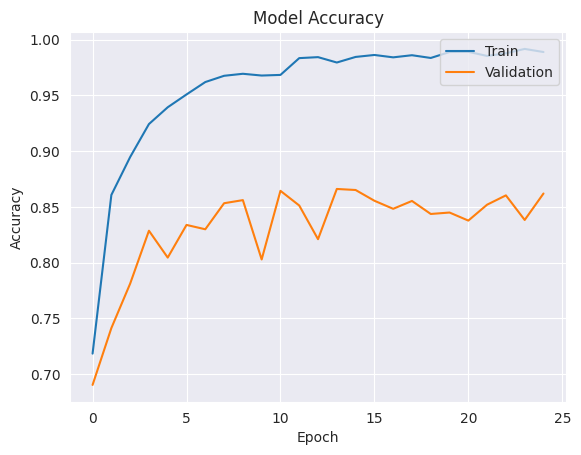

In [57]:
plt.plot(Xception_history.history['accuracy'])
plt.plot(Xception_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

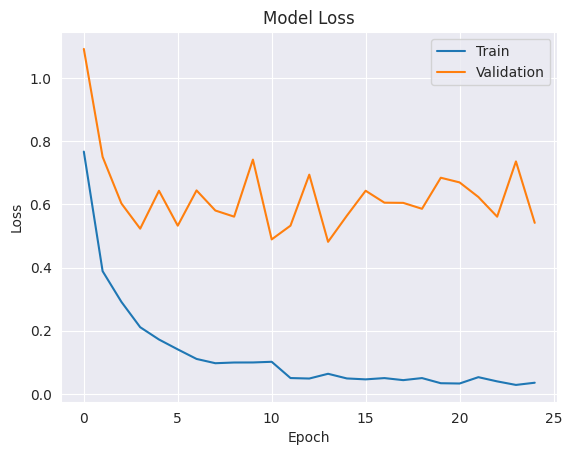

In [58]:
plt.plot(Xception_history.history['loss'])
plt.plot(Xception_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()